# 1. Imports and Constants

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numba import cuda

W = 0.5   # Inertia coefficient
C1 = 0.5  # Cognitive coefficient
C2 = 0.5  # Social coefficient
MAX_ITER = 100  # Maximal number of iterations
NUM_PARTICLES = 10_000  # Number of particles

DT = 0.5  # sub step = 0.5 => 2 Euler sub steps for 1 day
SUBSTEPS = 2  # 2 sub-steps of 0.5 = 1 day


# 2. Data loader

In [2]:
def load_covid_data(csv_path="/kaggle/input/cootiepatootie/ppp.csv"):
    df = pd.read_csv(csv_path, parse_dates=["Last_Update"])
    df = df.sort_values("Last_Update")
    return df.reset_index(drop=True)


# 3. GPU Kernels

In [3]:
@cuda.jit
def sird_RK4_gpu(  # noqa: PLR0912
    beta1_array,
    beta2_array,
    t1_array,
    t2_array,
    gamma_array,
    mu_array,
    cost_array,
    dt,
    substeps,
    Npop,
    days,
    I_emp,
    R_emp,
    D_emp,
    cost_type,
    S0,
    I0,
    R0,
    D0,
    use_norm,
    i_min,
    i_rng,
    r_min,
    r_rng,
    d_min,
    d_rng,
):
    pid = cuda.grid(1)
    if pid < beta1_array.size:
        beta1 = beta1_array[pid]
        beta2 = beta2_array[pid]
        t1 = t1_array[pid]
        t2 = t2_array[pid]
        gamma_ = gamma_array[pid]
        mu_ = mu_array[pid]

        # Initial conditions
        S = S0
        I = I0
        R = R0
        D = D0

        # Error accumulators
        err_I = 0.0
        err_R = 0.0
        err_D = 0.0

        max_err_ird_sq = 0.0
        max_err_d_sq = 0.0

        # Simulation
        for day_idx in range(days):

            for _ in range(substeps):

                # Time-dependent beta
                if day_idx < t1:
                    beta_t = beta1
                elif day_idx < t2:
                    frac = (day_idx - t1) / (t2 - t1 + 1e-8)
                    beta_t = beta1 + frac * (beta2 - beta1)
                else:
                    beta_t = beta2

                # --------------------
                # RK4 step
                # --------------------
                # k1
                dS1 = -beta_t * (S * I / Npop)
                dI1 = beta_t * (S * I / Npop) - (gamma_ + mu_) * I
                dR1 = gamma_ * I
                dD1 = mu_ * I

                S_temp = S + dS1 * (dt / 2)
                I_temp = I + dI1 * (dt / 2)
                R_temp = R + dR1 * (dt / 2)
                D_temp = D + dD1 * (dt / 2)

                dS2 = -beta_t * (S_temp * I_temp / Npop)
                dI2 = beta_t * (S_temp * I_temp / Npop) - (gamma_ + mu_) * I_temp
                dR2 = gamma_ * I_temp
                dD2 = mu_ * I_temp

                
                S_temp = S + dS2 * (dt / 2)
                I_temp = I + dI2 * (dt / 2)
                R_temp = R + dR2 * (dt / 2)
                D_temp = D + dD2 * (dt / 2)

                dS3 = -beta_t * (S_temp * I_temp / Npop)
                dI3 = beta_t * (S_temp * I_temp / Npop) - (gamma_ + mu_) * I_temp
                dR3 = gamma_ * I_temp
                dD3 = mu_ * I_temp

                S_temp = S + dS3 * dt
                I_temp = I + dI3 * dt
                R_temp = R + dR3 * dt
                D_temp = D + dD3 * dt

                dS4 = -beta_t * (S_temp * I_temp / Npop)
                dI4 = beta_t * (S_temp * I_temp / Npop) - (gamma_ + mu_) * I_temp
                dR4 = gamma_ * I_temp
                dD4 = mu_ * I_temp

                
                S_new = S + (dS1 + 2.0 * dS2 + 2.0 * dS3 + dS4) * (dt / 6.0)
                I_new = I + (dI1 + 2.0 * dI2 + 2.0 * dI3 + dI4) * (dt / 6.0)
                R_new = R + (dR1 + 2.0 * dR2 + 2.0 * dR3 + dR4) * (dt / 6.0)
                D_new = D + (dD1 + 2.0 * dD2 + 2.0 * dD3 + dD4) * (dt / 6.0)

                # Bound the values (avoid negative or unreasonably large)
                S_new = max(S_new, 0.0)
                I_new = max(I_new, 0.0)
                R_new = max(R_new, 0.0)
                D_new = max(D_new, 0.0)

                S_new = min(S_new, 1e15)
                I_new = min(I_new, 1e15)
                R_new = min(R_new, 1e15)
                D_new = min(D_new, 1e15)

                # Update
                S, I, R, D = S_new, I_new, R_new, D_new

            # Daily error computation
            if use_norm == 1:
                di = dr = dd = 0.0
                if i_rng > 1e-12:
                    di = (I - i_min) / i_rng - I_emp[day_idx]
                if r_rng > 1e-12:
                    dr = (R - r_min) / r_rng - R_emp[day_idx]
                if d_rng > 1e-12:
                    dd = (D - d_min) / d_rng - D_emp[day_idx]
            else:
                di = I - I_emp[day_idx]
                dr = R - R_emp[day_idx]
                dd = D - D_emp[day_idx]

            # Cost calculation
            if cost_type == 10:
                # Sum of squared errors for I, R, D
                err_I += di * di
                err_R += dr * dr
                err_D += dd * dd

            elif cost_type == 20:
                # Largest sum of squares for I, R, D
                sum_sq = di * di + dr * dr + dd * dd
                max_err_ird_sq = max(sum_sq, max_err_ird_sq)

            elif cost_type == 3:
                # Largest squared error for D alone
                sq = dd * dd
                max_err_d_sq = max(sq, max_err_d_sq)

            elif cost_type == 30:
                # Largest sum of squares for I, R, D
                sum_sq = di * di + dr * dr + dd * dd
                max_err_ird_sq = max(sum_sq, max_err_ird_sq)

        # After the day loop, write final cost
        if cost_type == 10:
            cost_array[pid] = (err_I + err_R + err_D) / days
        elif cost_type == 20:
            cost_array[pid] = max_err_ird_sq
        elif cost_type == 3:
            cost_array[pid] = max_err_d_sq
        elif cost_type == 30:
            cost_array[pid] = max_err_ird_sq
        else:
            cost_array[pid] = (err_I + err_R + err_D) / days

# 4. Function for plotting

In [4]:



def plot_all_trajectories_SIRD(
    all_trajectories,
    df,
    start_date,
    end_date,
    forecast_days=0,
    title="Multiple runs",
    population=38e6,
    tick_step=7,
):
    """
    We draw 4 subplots: S,I,R,D - all (N) runs + empirical points.
    """
    num_runs = len(all_trajectories)
    if num_runs == 0:
        print("No trajectory to draw.")
        return None

    L = len(all_trajectories[0][0])

    end_date_ext = end_date + pd.Timedelta(days=forecast_days)
    df_ext = df[
        (df["Last_Update"] >= start_date) & (df["Last_Update"] <= end_date_ext)
    ].copy()
    df_ext.reset_index(drop=True, inplace=True)

    x_data = np.arange(len(df_ext))
    date_labels = df_ext["Last_Update"].dt.strftime("%Y-%m-%d").values

    df_ext["S_calc"] = population - (
        df_ext["Active"] + df_ext["Recovered"] + df_ext["Deaths"]
    )

    S_emp_ext = df_ext["S_calc"].values
    I_emp_ext = df_ext["Active"].values
    R_emp_ext = df_ext["Recovered"].values
    D_emp_ext = df_ext["Deaths"].values

    fig, axs = plt.subplots(4, 1, figsize=(10, 14), sharex=True)

    fc_start_idx = L - forecast_days if forecast_days > 0 else L

    # S(t)
    for run_idx in range(num_runs):
        S_run = all_trajectories[run_idx][0]
        if forecast_days > 0:
            axs[0].plot(
                np.arange(fc_start_idx), S_run[:fc_start_idx], color="blue", alpha=0.03
            )
            axs[0].plot(
                np.arange(fc_start_idx, L),
                S_run[fc_start_idx:],
                color="magenta",
                alpha=0.03,
                linestyle="--",
            )
        else:
            axs[0].plot(S_run, color="blue", alpha=0.03)
    axs[0].plot(x_data, S_emp_ext, "ko", ms=3, label="Empiryczne S")
    axs[0].set_ylabel("S(t)")
    axs[0].legend()
    axs[0].set_title(f"S(t) – {title}")

    # I(t)
    for run_idx in range(num_runs):
        I_run = all_trajectories[run_idx][1]
        if forecast_days > 0:
            axs[1].plot(
                np.arange(fc_start_idx), I_run[:fc_start_idx], color="red", alpha=0.03
            )
            axs[1].plot(
                np.arange(fc_start_idx, L),
                I_run[fc_start_idx:],
                color="magenta",
                alpha=0.03,
                linestyle="--",
            )
        else:
            axs[1].plot(I_run, color="red", alpha=0.03)
    axs[1].plot(x_data, I_emp_ext, "ko", ms=3, label="Empiryczne I")
    axs[1].set_ylabel("I(t)")
    axs[1].legend()
    axs[1].set_title(f"I(t) – {title}")

    # R(t)
    for run_idx in range(num_runs):
        R_run = all_trajectories[run_idx][2]
        if forecast_days > 0:
            axs[2].plot(
                np.arange(fc_start_idx), R_run[:fc_start_idx], color="green", alpha=0.03
            )
            axs[2].plot(
                np.arange(fc_start_idx, L),
                R_run[fc_start_idx:],
                color="magenta",
                alpha=0.03,
                linestyle="--",
            )
        else:
            axs[2].plot(R_run, color="green", alpha=0.03)
    axs[2].plot(x_data, R_emp_ext, "ko", ms=3, label="Empiryczne R")
    axs[2].set_ylabel("R(t)")
    axs[2].legend()
    axs[2].set_title(f"R(t) – {title}")

    # D(t)
    for run_idx in range(num_runs):
        D_run = all_trajectories[run_idx][3]
        if forecast_days > 0:
            axs[3].plot(
                np.arange(fc_start_idx), D_run[:fc_start_idx], color="black", alpha=0.03
            )
            axs[3].plot(
                np.arange(fc_start_idx, L),
                D_run[fc_start_idx:],
                color="magenta",
                alpha=0.03,
                linestyle="--",
            )
        else:
            axs[3].plot(D_run, color="black", alpha=0.03)
    axs[3].plot(x_data, D_emp_ext, "ro", ms=3, label="Empiryczne D")
    axs[3].set_ylabel("D(t)")
    axs[3].legend()
    axs[3].set_title(f"D(t) – {title}")

    if forecast_days > 0:
        for ax in axs:
            ax.axvline(
                fc_start_idx, color="grey", linestyle="--", label="Start forecast"
            )

    xticks = np.arange(0, len(df_ext), tick_step)
    axs[3].set_xticks(xticks)
    axs[3].set_xticklabels(date_labels[xticks], rotation=90)
    axs[3].set_xlabel("Data")

    plt.tight_layout()
    return fig


def plot_compartments_fits(df, wresults, title_suffix="", save_path=None, ds=0):
    """
    We draw min-max envelopes based on wresults (window list),
    we superimpose the empirical data (I,R,D) on it.
    """
    T = len(df)
    x_dates = df["Last_Update"].values

    I_data = df["Active"].values if "Active" in df.columns else np.zeros(T)
    R_data = df["Recovered"].values if "Recovered" in df.columns else np.zeros(T)
    D_data = df["Deaths"].values if "Deaths" in df.columns else np.zeros(T)

    minI = np.full(T, np.inf)
    maxI = np.full(T, -np.inf)
    minR = np.full(T, np.inf)
    maxR = np.full(T, -np.inf)
    minD = np.full(T, np.inf)
    maxD = np.full(T, -np.inf)

    for res in wresults:
        start_day = res["start_day"]
        I_fit = res["I_fit"]
        R_fit = res["R_fit"]
        D_fit = res["D_fit"]

        for d in range(len(I_fit)):
            global_day = start_day + d
            if global_day < T:
                minI[global_day] = min(minI[global_day], I_fit[d])
                maxI[global_day] = max(maxI[global_day], I_fit[d])
                minR[global_day] = min(minR[global_day], R_fit[d])
                maxR[global_day] = max(maxR[global_day], R_fit[d])
                minD[global_day] = min(minD[global_day], D_fit[d])
                maxD[global_day] = max(maxD[global_day], D_fit[d])

    for arr in (minI, maxI, minR, maxR, minD, maxD):
        arr[np.isinf(arr)] = np.nan

    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    # I
    axes[0].fill_between(
        x_dates, minI, maxI, color="blue", alpha=0.3, label="I fit bounds"
    )
    axes[0].plot(x_dates, I_data, "k.", label="I empirical (Active)")
    axes[0].set_title(f"Active (I) {title_suffix}")
    axes[0].legend()

    # R
    axes[1].fill_between(
        x_dates, minR, maxR, color="green", alpha=0.3, label="R fit bounds"
    )
    axes[1].plot(x_dates, R_data, "k.", label="R empirical (Recovered)")
    axes[1].set_title(f"Recovered (R) {title_suffix}")
    axes[1].legend()

    # D
    axes[2].fill_between(
        x_dates, minD, maxD, color="red", alpha=0.3, label="D fit bounds"
    )
    axes[2].plot(x_dates, D_data, "k.", label="D empirical (Deaths)")
    axes[2].set_title(f"Deaths (D) {title_suffix}")
    axes[2].legend()

    if ds == 0:
        axes[0].set_ylim([0, 25000])

    for ax in axes:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        ax.tick_params(axis="x", rotation=45)

    plt.xlabel("Data")
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")

    plt.show()


def plot_params_wresults(df, wresults, title_suffix="", save_path=None):
    """
    Drawing 4 subplots:
      1) Beta(t) envelope
      2) Gamma(t) envelope
      3) Mu(t) envelope
      4) R0(t) envelope
    Based on results from window_wise_fitting (wresults).
    """

    T = len(df)
    x_dates = df["Last_Update"].values

    minBeta = np.full(T, np.inf)
    maxBeta = np.full(T, -np.inf)
    minGamma = np.full(T, np.inf)
    maxGamma = np.full(T, -np.inf)
    minMu = np.full(T, np.inf)
    maxMu = np.full(T, -np.inf)
    minR0 = np.full(T, np.inf)
    maxR0 = np.full(T, -np.inf)

    for res in wresults:
        start_day = res["start_day"]
        best_params = res["best_params"]

        beta1 = best_params["beta1"]
        beta2 = best_params["beta2"]
        t1 = best_params["t1"]
        t2 = best_params["t2"]
        gamma_ = best_params["gamma"]
        mu_ = best_params["mu"]

        window_size = len(res["I_fit"])

        for dlocal in range(window_size):
            dglobal = start_day + dlocal
            if dglobal >= T:
                break

            beta_d = piecewise_beta(dlocal, t1, t2, beta1, beta2)
            gamma_d = gamma_
            mu_d = mu_
            denom = max(gamma_d + mu_d, 1e-12)
            r0_d = beta_d / denom

            minBeta[dglobal] = min(minBeta[dglobal], beta_d)
            maxBeta[dglobal] = max(maxBeta[dglobal], beta_d)

            minGamma[dglobal] = min(minGamma[dglobal], gamma_d)
            maxGamma[dglobal] = max(maxGamma[dglobal], gamma_d)

            minMu[dglobal] = min(minMu[dglobal], mu_d)
            maxMu[dglobal] = max(maxMu[dglobal], mu_d)

            minR0[dglobal] = min(minR0[dglobal], r0_d)
            maxR0[dglobal] = max(maxR0[dglobal], r0_d)

    for arr in (minBeta, maxBeta, minGamma, maxGamma, minMu, maxMu, minR0, maxR0):
        arr[np.isinf(arr)] = np.nan

    fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

    axs[0].fill_between(
        x_dates, minBeta, maxBeta, color="blue", alpha=0.3, label="β(t) obwiednia"
    )
    axs[0].plot(x_dates, minBeta, color="blue", alpha=0.6)
    axs[0].plot(x_dates, maxBeta, color="blue", alpha=0.6)
    axs[0].set_ylabel("beta(t)")
    axs[0].set_title(f"β(t) {title_suffix}")
    axs[0].legend()

    axs[1].fill_between(
        x_dates, minGamma, maxGamma, color="green", alpha=0.3, label="γ(t) obwiednia"
    )
    axs[1].plot(x_dates, minGamma, color="green", alpha=0.6)
    axs[1].plot(x_dates, maxGamma, color="green", alpha=0.6)
    axs[1].set_ylabel("gamma")
    axs[1].set_title(f"γ(t) {title_suffix}")
    axs[1].legend()

    axs[2].fill_between(
        x_dates, minMu, maxMu, color="red", alpha=0.3, label="μ(t) obwiednia"
    )
    axs[2].plot(x_dates, minMu, color="red", alpha=0.6)
    axs[2].plot(x_dates, maxMu, color="red", alpha=0.6)
    axs[2].set_ylabel("mu")
    axs[2].set_title(f"μ(t) {title_suffix}")
    axs[2].legend()

    axs[3].fill_between(
        x_dates, minR0, maxR0, color="orange", alpha=0.3, label="R0(t) obwiednia"
    )
    axs[3].plot(x_dates, minR0, color="orange", alpha=0.6)
    axs[3].plot(x_dates, maxR0, color="orange", alpha=0.6)
    axs[3].set_ylabel("R0(t)")
    axs[3].set_title(f"R0(t) = β(t)/(γ+μ) {title_suffix}")
    axs[3].legend()

    for ax in axs:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        ax.tick_params(axis="x", rotation=45)

    plt.xlabel("Data")
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")

    plt.show()


# 5. SIRD Model

In [5]:
def piecewise_beta(d, t1, t2, beta1, beta2):
    if d < t1:
        return beta1
    if d < t2:
        frac = (d - t1) / max((t2 - t1), 1e-8)
        return beta1 + frac * (beta2 - beta1)
    return beta2


def simulate_sird(params, days, S0, I0, R0, D0, dt=0.5, substeps=2, Npop=38e6):
    beta1 = params["beta1"]
    beta2 = params["beta2"]
    t1 = params["t1"]
    t2 = params["t2"]
    gamma_ = params["gamma"]
    mu_ = params["mu"]

    S_arr = np.zeros(days)
    I_arr = np.zeros(days)
    R_arr = np.zeros(days)
    D_arr = np.zeros(days)

    S = S0
    I = I0
    R = R0
    D = D0

    for day_idx in range(days):
        S_arr[day_idx] = S
        I_arr[day_idx] = I
        R_arr[day_idx] = R
        D_arr[day_idx] = D

        for _ in range(substeps):
            if day_idx < t1:
                beta_t = beta1
            elif day_idx < t2:
                frac = (day_idx - t1) / (t2 - t1 + 1e-8)
                beta_t = beta1 + frac * (beta2 - beta1)
            else:
                beta_t = beta2

            dS = -beta_t * (S * I / Npop)
            dI = beta_t * (S * I / Npop) - (gamma_ + mu_) * I
            dR = gamma_ * I
            dD = mu_ * I

            S_new = S + dS * dt
            I_new = I + dI * dt
            R_new = R + dR * dt
            D_new = D + dD * dt

            S_new = max(S_new, 0)
            I_new = max(I_new, 0)
            R_new = max(R_new, 0)
            D_new = max(D_new, 0)

            S_new = min(S_new, 1e15)
            I_new = min(I_new, 1e15)
            R_new = min(R_new, 1e15)
            D_new = min(D_new, 1e15)

            S, I, R, D = S_new, I_new, R_new, D_new

    return S_arr, I_arr, R_arr, D_arr


# 6. PSO

In [6]:
def run_pso_sird_gpu(
    days,
    D_emp,
    I_emp=None,
    R_emp=None,
    S0=0.0,
    I0=0.0,
    R0=0.0,
    D0=0.0,
    dt=DT,
    substeps=SUBSTEPS,
    Npop=38e6,
    n_particles=1000,
    max_iter=50,
    cost_type=10,
    # bounds
    bounds_beta1=(0.0, 1.5),
    bounds_beta2=(0.0, 1.5),
    bounds_t1=(0.0, 10.0),
    bounds_t2=(10.0, 36.0),
    bounds_gamma=(0.0, 0.3),
    bounds_mu=(0.0, 0.05),
    # normalize
    use_norm=False,
    i_min=0.0,
    i_rng=1.0,
    r_min=0.0,
    r_rng=1.0,
    d_min=0.0,
    d_rng=1.0,
    W=W,
    C1=C1,
    C2=C2,
):
    """
    The main PSO function that returns:
    - gbest_params: dict with best parameters
    - history: a list of the best cost values in each iteration
    """

    if I_emp is None:
        I_emp = np.zeros(days, dtype=np.float32)
    if R_emp is None:
        R_emp = np.zeros(days, dtype=np.float32)

    # Initialize
    beta1 = np.random.uniform(bounds_beta1[0], bounds_beta1[1], n_particles)
    beta2 = np.random.uniform(bounds_beta2[0], bounds_beta2[1], n_particles)
    t1_ = np.random.uniform(bounds_t1[0], bounds_t1[1], n_particles)
    t2_ = np.random.uniform(bounds_t2[0], bounds_t2[1], n_particles)
    gamma_ = np.random.uniform(bounds_gamma[0], bounds_gamma[1], n_particles)
    mu_ = np.random.uniform(bounds_mu[0], bounds_mu[1], n_particles)

    v_beta1 = np.zeros(n_particles)
    v_beta2 = np.zeros(n_particles)
    v_t1 = np.zeros(n_particles)
    v_t2 = np.zeros(n_particles)
    v_gamma = np.zeros(n_particles)
    v_mu = np.zeros(n_particles)

    pbest_beta1 = beta1.copy()
    pbest_beta2 = beta2.copy()
    pbest_t1 = t1_.copy()
    pbest_t2 = t2_.copy()
    pbest_gamma = gamma_.copy()
    pbest_mu = mu_.copy()
    pbest_cost = np.ones(n_particles) * 1e30

    gbest_cost = 1e30
    gbest_params = {}

    # Convert to float32 and copy to GPU.
    d_emp_f32 = D_emp.astype(np.float32)
    i_emp_f32 = I_emp.astype(np.float32)
    r_emp_f32 = R_emp.astype(np.float32)

    D_emp_dev = cuda.to_device(d_emp_f32)
    I_emp_dev = cuda.to_device(i_emp_f32)
    R_emp_dev = cuda.to_device(r_emp_f32)

    beta1_dev = cuda.to_device(beta1.astype(np.float32))
    beta2_dev = cuda.to_device(beta2.astype(np.float32))
    t1_dev = cuda.to_device(t1_.astype(np.float32))
    t2_dev = cuda.to_device(t2_.astype(np.float32))
    gamma_dev = cuda.to_device(gamma_.astype(np.float32))
    mu_dev = cuda.to_device(mu_.astype(np.float32))

    cost_dev = cuda.device_array(n_particles, dtype=np.float32)

    use_norm_flag = 1 if use_norm else 0
    norm_data = np.array([i_min, i_rng, r_min, r_rng, d_min, d_rng], dtype=np.float32)
    norm_data_dev = cuda.to_device(norm_data)

    threadsperblock = 128
    blockspergrid = (n_particles + threadsperblock - 1) // threadsperblock

    history = []

    for it in range(max_iter):
        # 1) Kernel on GPU
        sird_RK4_gpu[blockspergrid, threadsperblock](
            beta1_dev,
            beta2_dev,
            t1_dev,
            t2_dev,
            gamma_dev,
            mu_dev,
            cost_dev,
            dt,
            substeps,
            Npop,
            days,
            I_emp_dev,
            R_emp_dev,
            D_emp_dev,
            cost_type,
            S0,
            I0,
            R0,
            D0,
            use_norm_flag,
            norm_data_dev[0],
            norm_data_dev[1],
            norm_data_dev[2],
            norm_data_dev[3],
            norm_data_dev[4],
            norm_data_dev[5],
        )
        cuda.synchronize()

        # 2) Matching cost with GPU
        cost_vals = cost_dev.copy_to_host()

        # 3) Update pbest
        better_idx = cost_vals < pbest_cost
        pbest_cost[better_idx] = cost_vals[better_idx]
        pbest_beta1[better_idx] = beta1[better_idx]
        pbest_beta2[better_idx] = beta2[better_idx]
        pbest_t1[better_idx] = t1_[better_idx]
        pbest_t2[better_idx] = t2_[better_idx]
        pbest_gamma[better_idx] = gamma_[better_idx]
        pbest_mu[better_idx] = mu_[better_idx]

        # 4) Update gbest
        min_cost_idx = np.argmin(cost_vals)
        min_cost_val = cost_vals[min_cost_idx]
        if min_cost_val < gbest_cost:
            gbest_cost = min_cost_val
            gbest_params = {
                "beta1": beta1[min_cost_idx],
                "beta2": beta2[min_cost_idx],
                "t1": t1_[min_cost_idx],
                "t2": t2_[min_cost_idx],
                "gamma": gamma_[min_cost_idx],
                "mu": mu_[min_cost_idx],
            }

        history.append(gbest_cost)

        # 5) Speed and position update
        r1 = np.random.rand(n_particles)
        r2 = np.random.rand(n_particles)
        v_beta1 = (
            W * v_beta1
            + C1 * r1 * (pbest_beta1 - beta1)
            + C2 * r2 * (gbest_params["beta1"] - beta1)
        )
        beta1 += v_beta1

        r1 = np.random.rand(n_particles)
        r2 = np.random.rand(n_particles)
        v_beta2 = (
            W * v_beta2
            + C1 * r1 * (pbest_beta2 - beta2)
            + C2 * r2 * (gbest_params["beta2"] - beta2)
        )
        beta2 += v_beta2

        r1 = np.random.rand(n_particles)
        r2 = np.random.rand(n_particles)
        v_t1 = (
            W * v_t1 + C1 * r1 * (pbest_t1 - t1_) + C2 * r2 * (gbest_params["t1"] - t1_)
        )
        t1_ += v_t1

        r1 = np.random.rand(n_particles)
        r2 = np.random.rand(n_particles)
        v_t2 = (
            W * v_t2 + C1 * r1 * (pbest_t2 - t2_) + C2 * r2 * (gbest_params["t2"] - t2_)
        )
        t2_ += v_t2

        r1 = np.random.rand(n_particles)
        r2 = np.random.rand(n_particles)
        v_gamma = (
            W * v_gamma
            + C1 * r1 * (pbest_gamma - gamma_)
            + C2 * r2 * (gbest_params["gamma"] - gamma_)
        )
        gamma_ += v_gamma

        r1 = np.random.rand(n_particles)
        r2 = np.random.rand(n_particles)
        v_mu = (
            W * v_mu + C1 * r1 * (pbest_mu - mu_) + C2 * r2 * (gbest_params["mu"] - mu_)
        )
        mu_ += v_mu

        # 6) clip
        beta1 = np.clip(beta1, bounds_beta1[0], bounds_beta1[1])
        beta2 = np.clip(beta2, bounds_beta2[0], bounds_beta2[1])
        t1_ = np.clip(t1_, bounds_t1[0], bounds_t1[1])
        t2_ = np.clip(t2_, bounds_t2[0], bounds_t2[1])
        gamma_ = np.clip(gamma_, bounds_gamma[0], bounds_gamma[1])
        mu_ = np.clip(mu_, bounds_mu[0], bounds_mu[1])

        # 7) Copying back to the GPU
        beta1_dev.copy_to_device(beta1.astype(np.float32))
        beta2_dev.copy_to_device(beta2.astype(np.float32))
        t1_dev.copy_to_device(t1_.astype(np.float32))
        t2_dev.copy_to_device(t2_.astype(np.float32))
        gamma_dev.copy_to_device(gamma_.astype(np.float32))
        mu_dev.copy_to_device(mu_.astype(np.float32))

    return gbest_params, history


# 7. Window Fitting

In [7]:
def multiple_runs_fit_sird(
    df,
    start_date,
    end_date,
    num_runs=1000,
    cost_type=20,
    use_norm=True,
    n_particles=NUM_PARTICLES,
    max_iter=MAX_ITER,
    forecast_days=0,
    population=38e6,
    DT=DT,
    SUBSTEPS=SUBSTEPS,
):
    """
    Performs num_runs of PSO matches in the selected [start_date..end_date] window.
    Returns a list (S,I,R,D) of length (days_window + forecast_days) for each trial.
    """
    dfw = df[(df["Last_Update"] >= start_date) & (df["Last_Update"] <= end_date)].copy()
    dfw.reset_index(drop=True, inplace=True)
    days_window = len(dfw)
    if days_window < 2:
        print("Za mało danych w oknie:", start_date, end_date)
        return []

    I_emp = dfw["Active"].values.astype(float)
    R_emp = dfw["Recovered"].values.astype(float)
    D_emp = dfw["Deaths"].values.astype(float)

    # Initial conditions
    row0 = dfw.iloc[0]
    S0 = population - (row0["Active"] + row0["Recovered"] + row0["Deaths"])
    I0 = row0["Active"]
    R0 = row0["Recovered"]
    D0 = row0["Deaths"]

    # Normalize
    if use_norm:
        i_min, i_max = I_emp.min(), I_emp.max()
        r_min, r_max = R_emp.min(), R_emp.max()
        d_min, d_max = D_emp.min(), D_emp.max()
        i_rng = max(i_max - i_min, 1e-6)
        r_rng = max(r_max - r_min, 1e-6)
        d_rng = max(d_max - d_min, 1e-6)

        I_emp_norm = (I_emp - i_min) / i_rng
        R_emp_norm = (R_emp - r_min) / r_rng
        D_emp_norm = (D_emp - d_min) / d_rng
    else:
        I_emp_norm = I_emp
        R_emp_norm = R_emp
        D_emp_norm = D_emp
        i_min, i_rng = 0.0, 1.0
        r_min, r_rng = 0.0, 1.0
        d_min, d_rng = 0.0, 1.0

    all_trajectories = []
    for run_idx in range(num_runs):
        gbest_params, hist = run_pso_sird_gpu(
            days=days_window,
            D_emp=D_emp_norm,
            I_emp=I_emp_norm,
            R_emp=R_emp_norm,
            S0=S0,
            I0=I0,
            R0=R0,
            D0=D0,
            dt=DT,
            substeps=SUBSTEPS,
            Npop=population,
            n_particles=n_particles,
            max_iter=max_iter,
            cost_type=cost_type,
            use_norm=use_norm,
            i_min=i_min,
            i_rng=i_rng,
            r_min=r_min,
            r_rng=r_rng,
            d_min=d_min,
            d_rng=d_rng,
        )

        # “Fit in the window” simulation
        S_fit, I_fit, R_fit, D_fit = simulate_sird(
            gbest_params,
            days_window,
            S0,
            I0,
            R0,
            D0,
            dt=DT,
            substeps=SUBSTEPS,
            Npop=population,
        )

        # Forecast
        if forecast_days > 0:
            s_last = S_fit[-1]
            i_last = I_fit[-1]
            r_last = R_fit[-1]
            d_last = D_fit[-1]

            beta2 = gbest_params["beta2"]
            gamma_ = gbest_params["gamma"]
            mu_ = gbest_params["mu"]
            tmp_params = {
                "beta1": beta2,
                "beta2": beta2,
                "t1": 0,
                "t2": 0,
                "gamma": gamma_,
                "mu": mu_,
            }
            S_ext, I_ext, R_ext, D_ext = simulate_sird(
                tmp_params,
                forecast_days,
                s_last,
                i_last,
                r_last,
                d_last,
                dt=DT,
                substeps=SUBSTEPS,
                Npop=population,
            )

            S_full = np.concatenate([S_fit, S_ext])
            I_full = np.concatenate([I_fit, I_ext])
            R_full = np.concatenate([R_fit, R_ext])
            D_full = np.concatenate([D_fit, D_ext])
        else:
            S_full = S_fit
            I_full = I_fit
            R_full = R_fit
            D_full = D_fit

        all_trajectories.append((S_full, I_full, R_full, D_full))

    return all_trajectories


def window_wise_fitting(
    df,
    population=38e6,
    window_size=36,
    step=3,
    cost_type=30,
    n_particles=NUM_PARTICLES,
    max_iter=MAX_ITER,
    use_norm=False,
    i_min=0.0,
    i_rng=1.0,
    r_min=0.0,
    r_rng=1.0,
    d_min=0.0,
    d_rng=1.0,
    DT=DT,
    SUBSTEPS=SUBSTEPS,
):
    """
    We take a window of 36 days, move every 3 days,
    we adjust the SIRD parameters in this window to I,R,D with cost_type=30 (MXSE(IRD)).
    """
    T = len(df)
    results = []

    for start_day in range(0, T - window_size + 1, step):
        df_window = df.iloc[start_day : start_day + window_size]

        D_emp = df_window["Deaths"].values
        I_emp = (
            df_window["Active"].values
            if "Active" in df_window.columns
            else np.zeros_like(D_emp)
        )
        R_emp = (
            df_window["Recovered"].values
            if "Recovered" in df_window.columns
            else np.zeros_like(D_emp)
        )

        # Initial conditions
        row_0 = df_window.iloc[0]
        S0 = population - (row_0["Active"] + row_0["Recovered"] + row_0["Deaths"])
        I0 = row_0["Active"]
        R0 = row_0["Recovered"]
        D0 = row_0["Deaths"]

        gbest_params, hist = run_pso_sird_gpu(
            days=window_size,
            D_emp=D_emp,
            I_emp=I_emp,
            R_emp=R_emp,
            S0=S0,
            I0=I0,
            R0=R0,
            D0=D0,
            dt=DT,
            substeps=SUBSTEPS,
            Npop=population,
            n_particles=n_particles,
            max_iter=max_iter,
            cost_type=cost_type,
            use_norm=use_norm,
            i_min=i_min,
            i_rng=i_rng,
            r_min=r_min,
            r_rng=r_rng,
            d_min=d_min,
            d_rng=d_rng,
        )

        S_fit, I_fit, R_fit, D_fit = simulate_sird(
            gbest_params,
            window_size,
            S0,
            I0,
            R0,
            D0,
            dt=DT,
            substeps=SUBSTEPS,
            Npop=population,
        )

        results.append({
            "start_day": start_day,
            "best_params": gbest_params,
            "cost_history": hist,
            "S_fit": S_fit,
            "I_fit": I_fit,
            "R_fit": R_fit,
            "D_fit": D_fit,
        })

    return results


# 8. Main execution

In [8]:
def main():
    csv_path = "/kaggle/input/dadsadas/covid-19-preprocessed.csv"
    df = load_covid_data(csv_path)
    print("[INFO] Data loaded. Rows =", len(df))

    start_date_1 = pd.to_datetime("2020-05-10")
    end_date_1 = pd.to_datetime("2020-06-13")
    start_date_2 = pd.to_datetime("2021-04-04")
    end_date_2 = pd.to_datetime("2021-05-08")
    forecast_days = 21

    all_traj_1 = multiple_runs_fit_sird(
        df,
        start_date_1,
        end_date_1,
        num_runs=1000,
        cost_type=30,
        use_norm=True,
        n_particles=NUM_PARTICLES,
        max_iter=MAX_ITER,
        forecast_days=forecast_days,
        population=38e6,
    )
    fig1 = plot_all_trajectories_SIRD(
        all_traj_1,
        df,
        start_date_1,
        end_date_1,
        forecast_days=forecast_days,
        title=f"Okno1: {start_date_1.date()}..{end_date_1.date()} (cost=MXSE(IRD))",
    )
    if fig1 is not None:
        plt.show(fig1)
        fig1.savefig("1000repetitions_2020_05_10.pdf")
        plt.close(fig1)

    # 3) Drugie okno
    all_traj_2 = multiple_runs_fit_sird(
        df,
        start_date_2,
        end_date_2,
        num_runs=1000,
        cost_type=30,
        use_norm=True,
        n_particles=NUM_PARTICLES,
        max_iter=MAX_ITER,
        forecast_days=forecast_days,
        population=38e6,
    )
    fig2 = plot_all_trajectories_SIRD(
        all_traj_2,
        df,
        start_date_2,
        end_date_2,
        forecast_days=forecast_days,
        title=f"Window2: {start_date_2.date()}..{end_date_2.date()} (cost=MXSE(IRD))",
    )
    if fig2 is not None:
        plt.show(fig2)
        fig2.savefig("1000_repetitions_2021_.pdf")
        plt.close(fig2)

    # 4) Okienkowe dopasowanie
    df_before = df[df["Last_Update"] <= "2020-10-20"].copy()
    wresults_before = window_wise_fitting(
        df=df_before,
        population=38e6,
        window_size=36,
        step=7,
        cost_type=30,
        n_particles=NUM_PARTICLES,
        max_iter=MAX_ITER,
        use_norm=False,
    )
    plot_compartments_fits(
        df_before,
        wresults_before,
        title_suffix="(do 20.10.2020)",
        save_path="plot_fitting_20102020.pdf",
    )

    df_after = df[df["Last_Update"] > "2020-10-20"].copy()
    wresults_after = window_wise_fitting(
        df=df_after,
        population=38e6,
        window_size=36,
        step=7,
        cost_type=30,
        n_particles=NUM_PARTICLES,
        max_iter=MAX_ITER,
        use_norm=False,
    )
    plot_compartments_fits(
        df_after,
        wresults_after,
        title_suffix="(od 21.10.2020)",
        save_path="plot_after_20102020.pdf",
        ds=1,
    )

    plot_params_wresults(
        df_before,
        wresults_before,
        title_suffix="(do 20.10.2020)",
        save_path="params1_20102020.pdf",
    )
    plot_params_wresults(
        df_after,
        wresults_after,
        title_suffix="(od 21.10.2020)",
        save_path="params_2_after_20102020.pdf",
    )

    print("\n[DONE] Skrypt zakończył działanie.")


[INFO] Data loaded. Rows = 498


/usr/local/lib/python3.10/dist-packages/numba_cuda/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 79 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


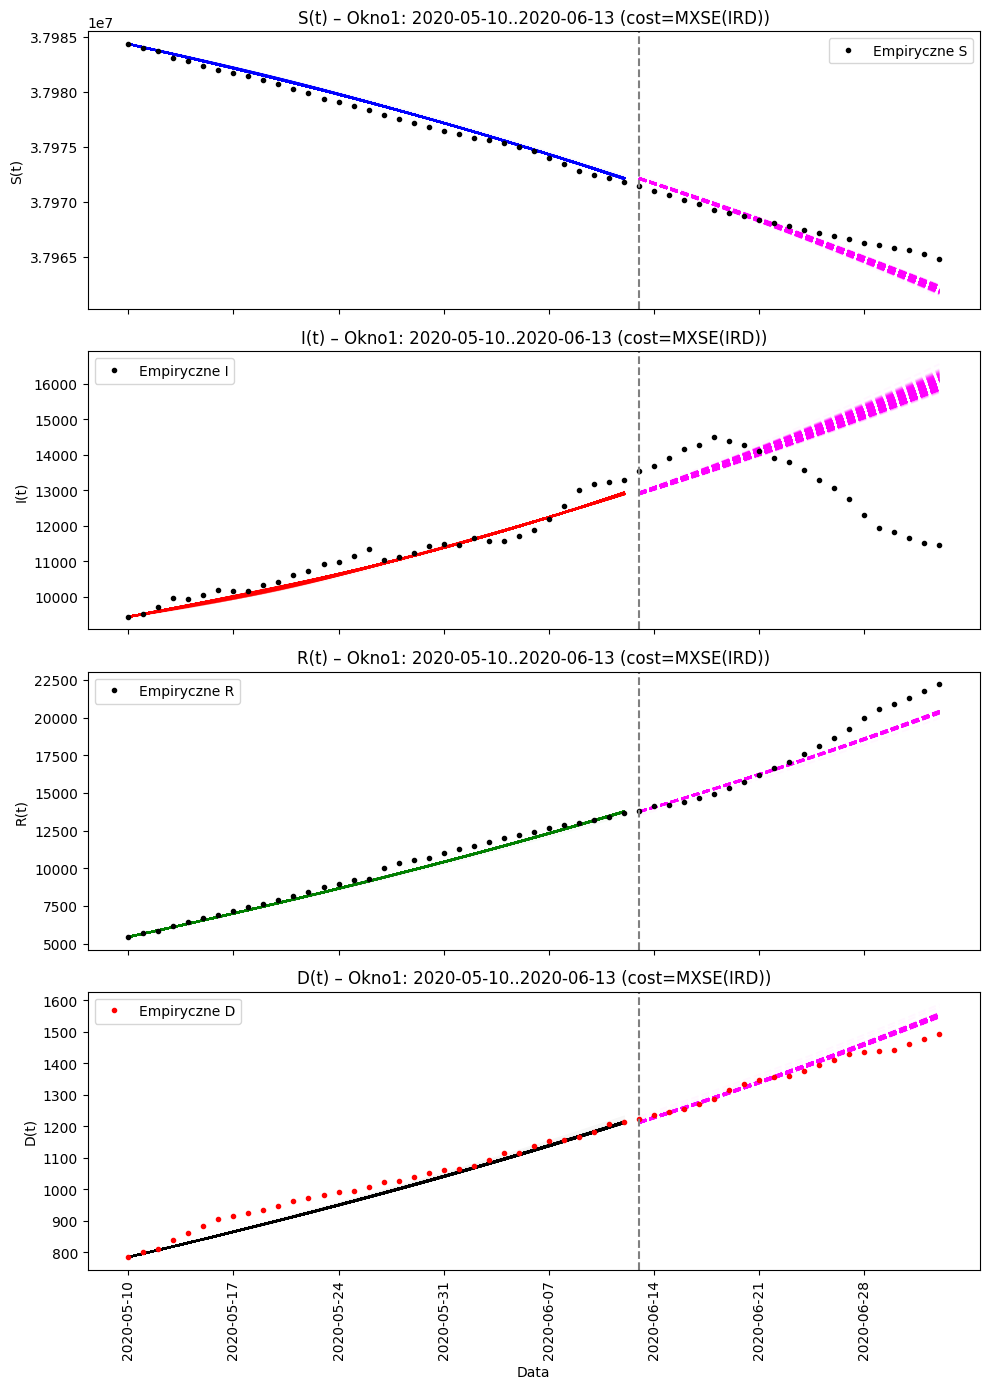

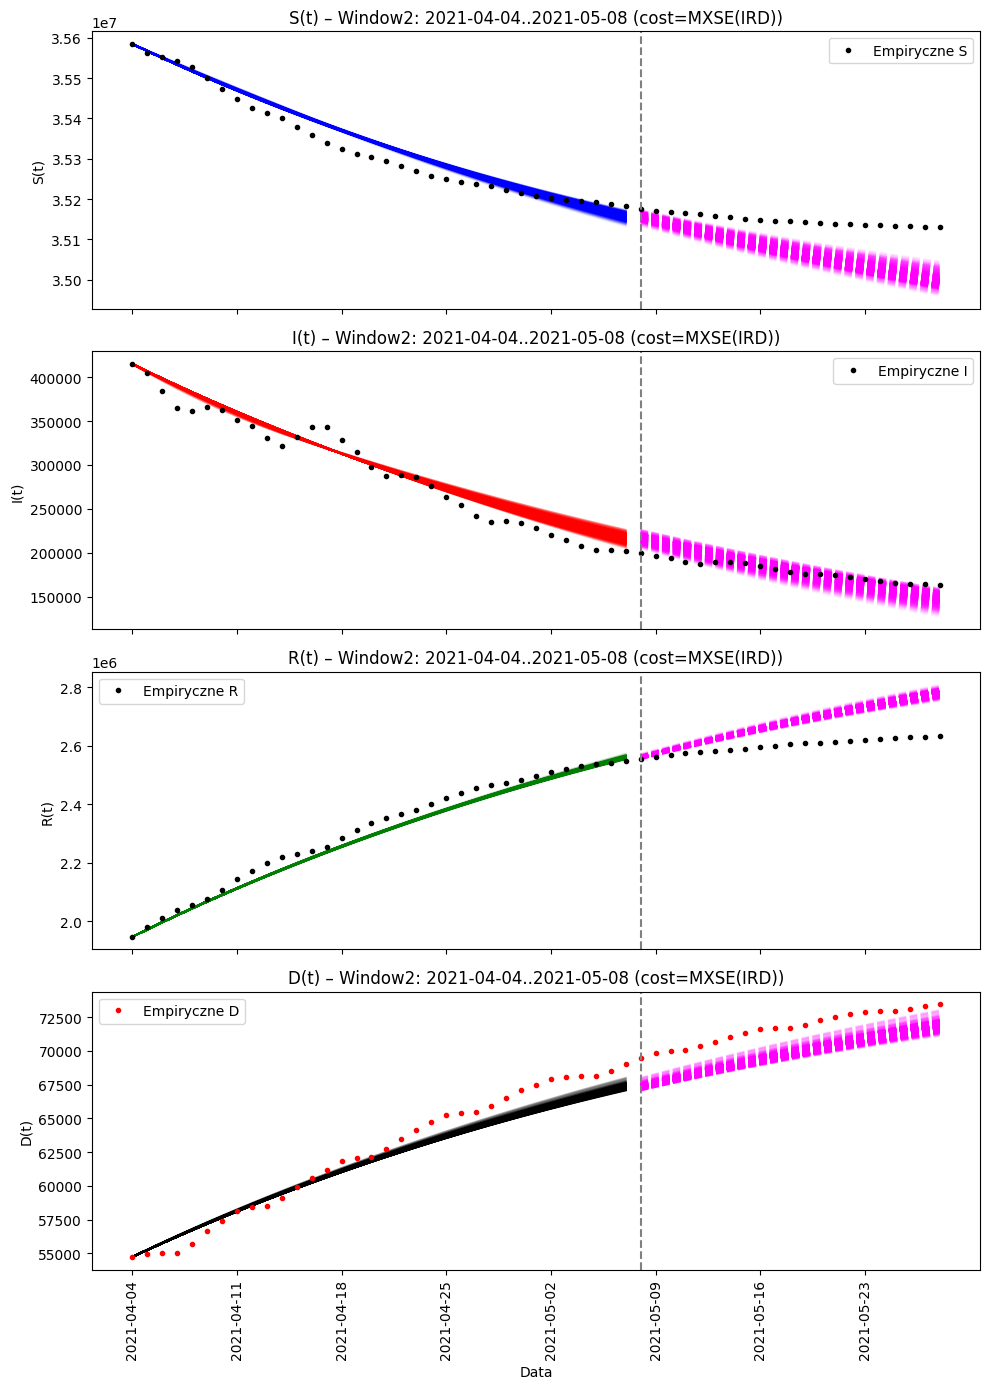

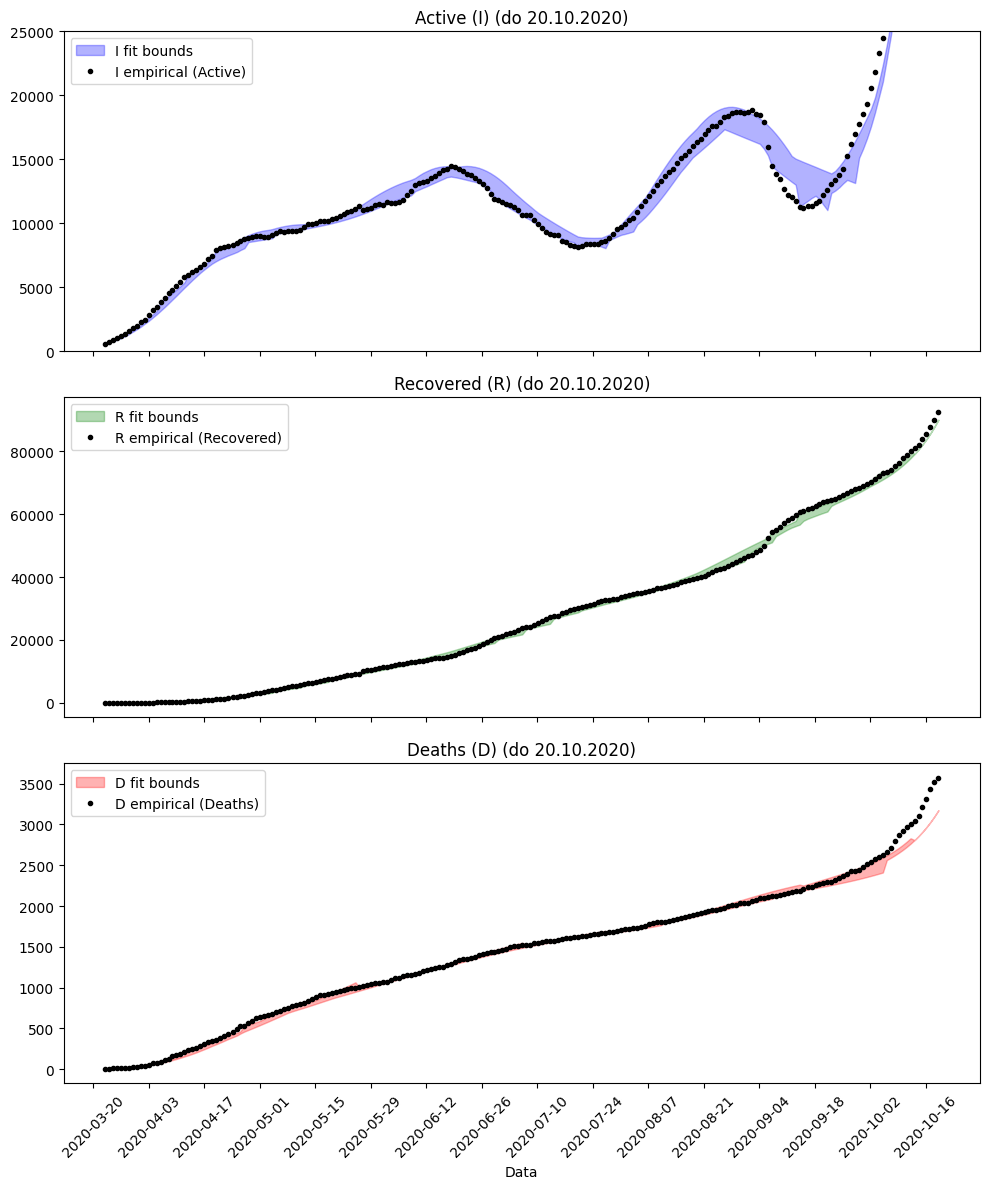

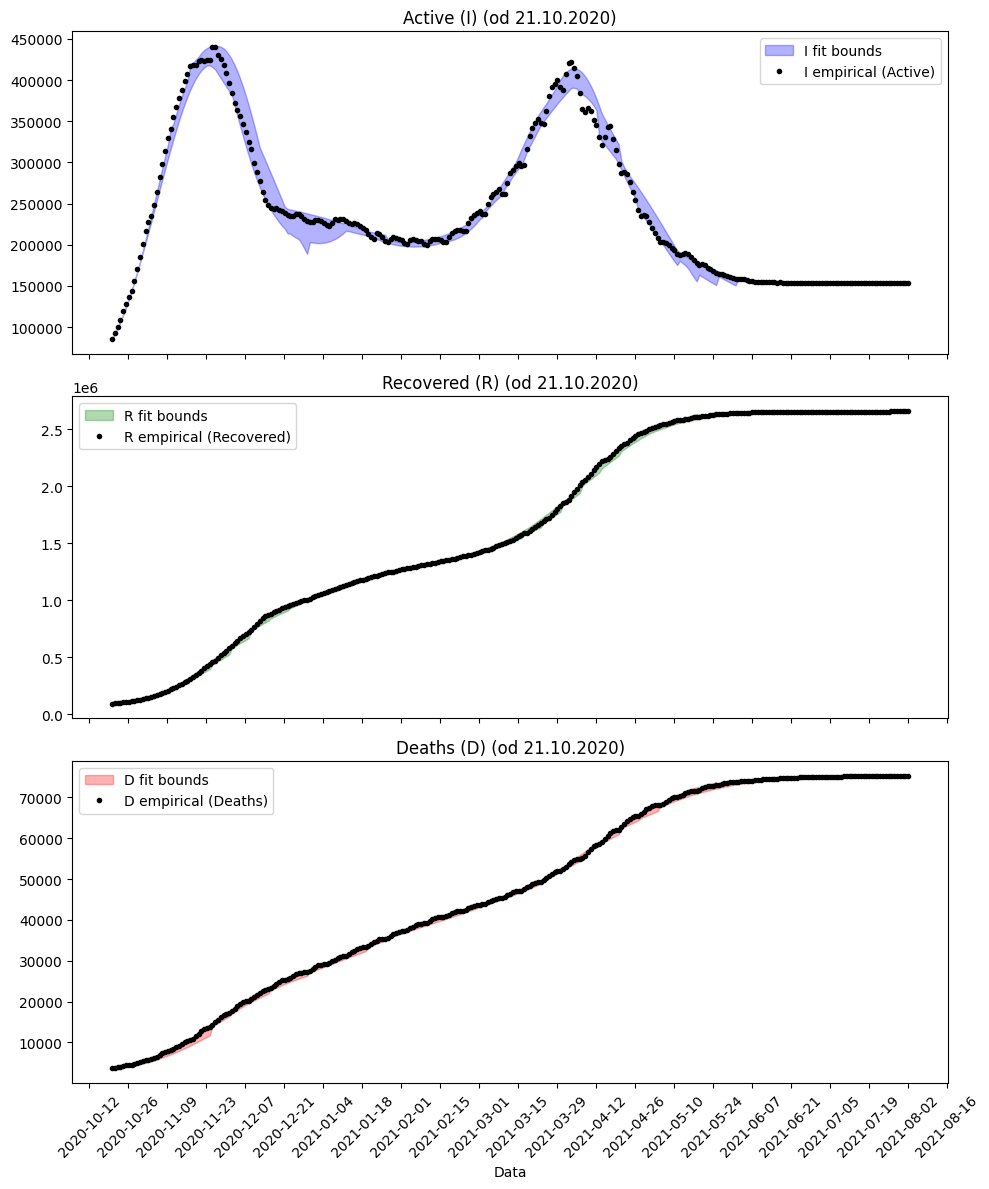

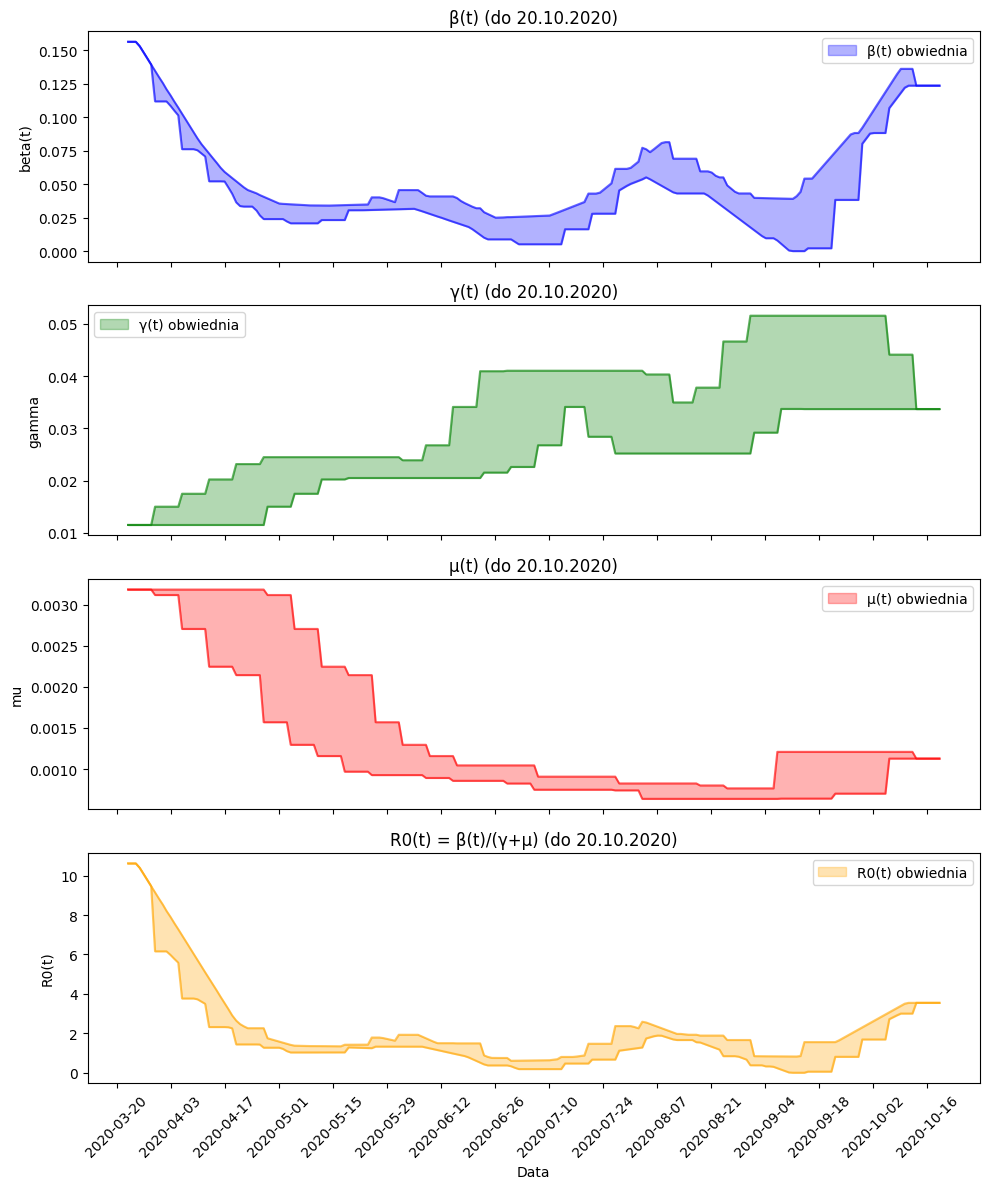

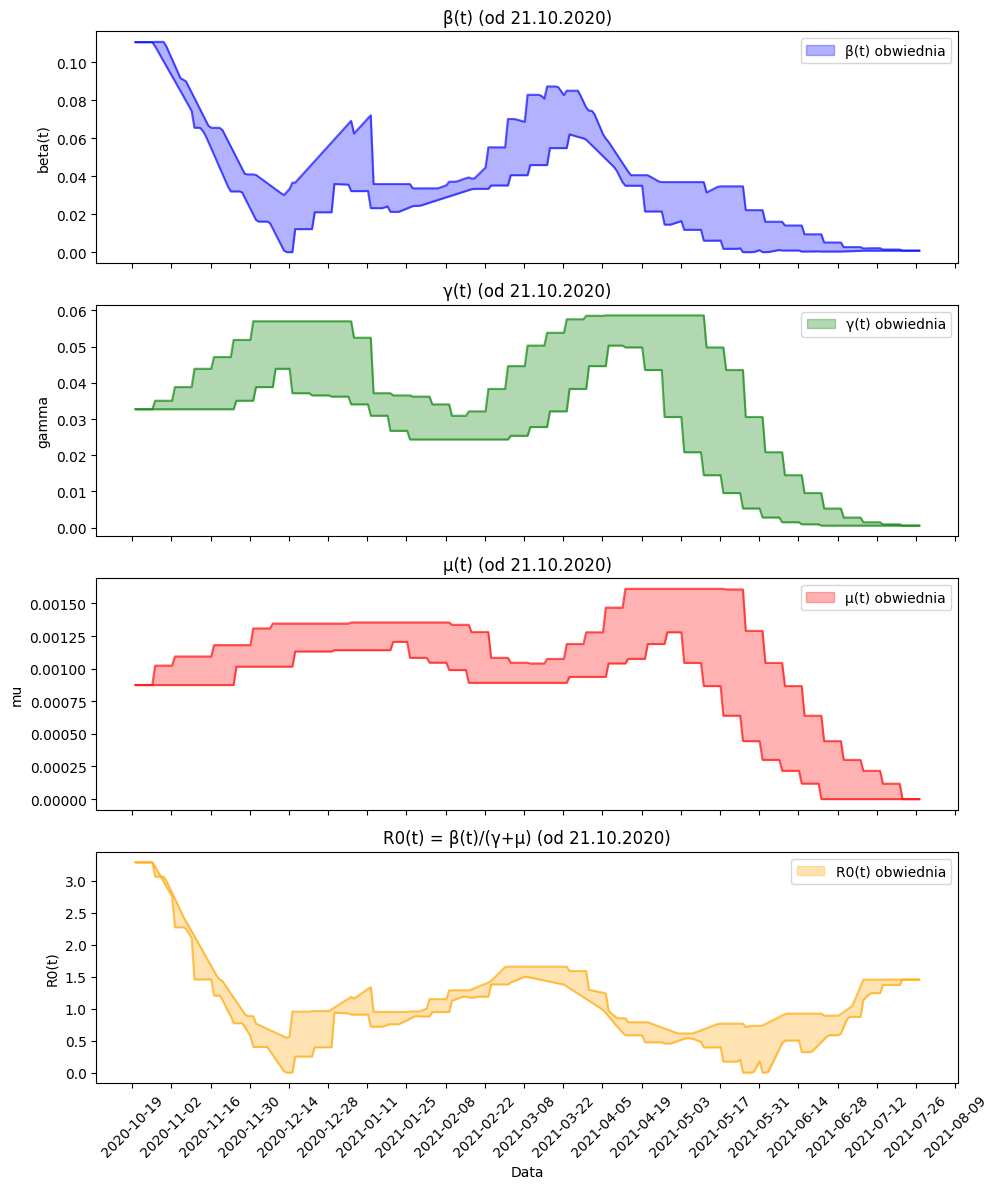


[DONE] Skrypt zakończył działanie.


In [9]:
main()